# "Backtesting with your own custom strategy"
> "Write your own buy and sell signals from custom indicators and built-in indicators"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Benj Del Mundo
- categories: [backtest, custom strategy]

In [1]:
# uncomment to install in colab
# !pip3 install fastquant

In [2]:
from fastquant import backtest,get_stock_data
import numpy as np

In [3]:
df = get_stock_data("SMC",start_date='2019-01-01',end_date='2019-06-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,open,high,low,close,volume
dt,,,,,
2018-12-31,13681.799805,13681.799805,13681.799805,13681.799805,0
2019-01-02,13636.400391,14000.000000,13454.500000,13909.099609,4862
2019-01-03,13181.799805,13863.599609,13000.000000,13863.599609,594
2019-01-04,13863.599609,13863.599609,13454.500000,13636.400391,3432
2019-01-07,13863.599609,13863.599609,13090.900391,13090.900391,18183


## Create our own custom indicator. In this case, we'll use scipy implementation of Arnaud Legoux Moving Average (ALMA)

> Arnaud Legoux Moving Average (ALMA) removes small price fluctuations and enhances the trend by applying a moving average twice, once from left to right, and once from right to left. At the end of this process the phase shift (price lag) commonly associated with moving averages is significantly reduced

(https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/arnaudlegoux.htm)


In [5]:
from scipy.ndimage import convolve1d as conv

def alma_indicator(data,window=9,offset=0.85,sigma=6):
    m = int(offset * window-1)
    s = window/sigma
    dss = 2*s*s
    wtds = np.exp(-(np.arange(window) - m)**2/dss)
    return conv(data, weights=wtds/wtds.sum(),axis=0, mode='nearest')

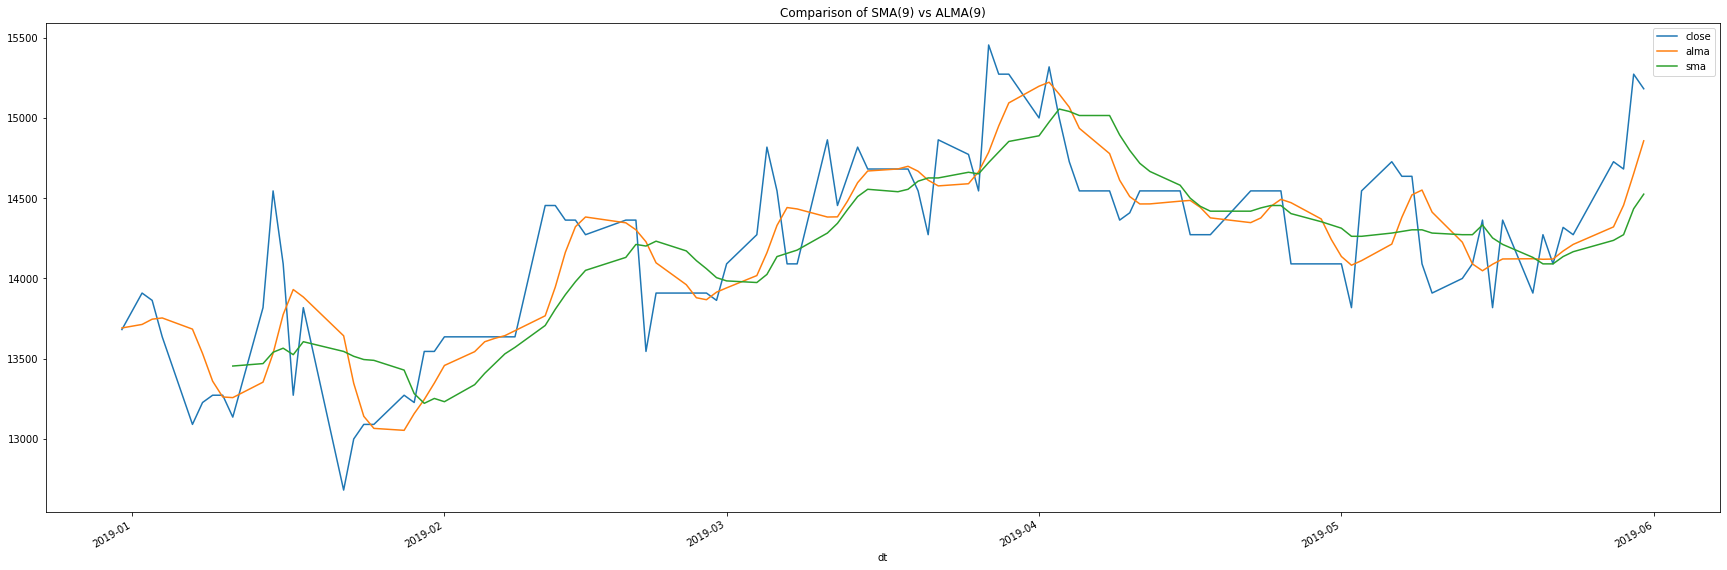

In [6]:
%matplotlib inline
df["alma"] = alma_indicator(df.close, window=9,offset=0.85,sigma=6)
df["sma"] = df.close.rolling(9).mean()


df[["close","alma","sma"]].plot(figsize=(30,10),title="Comparison of SMA(9) vs ALMA(9)")

In [7]:
import backtrader as bt
from fastquant import CustomStrategy, BaseStrategy
from fastquant.indicators import MACD
from fastquant.indicators.custom import CustomIndicator

## Implementing our custom strategy

In this strategy we will have the following signals:

Buy on:
- Closing price is above ALMA
- MACD crosses above the MACD signal line
- Set a risk tolerance of 5% from ALMA

Sell on:
- Closing price falls below ALMA

In [11]:
# Create a subclass of the BaseStrategy
class MAMAStrategy(BaseStrategy):
    
    params = (
        ("alma_column", "alma"),
        ("macd_fast_period", 12),  # period for the MACD
        ("macd_slow_period", 16),
        ("macd_signal_period",9)
    )

    def __init__(self):
        # Initialize global variables
        super().__init__()
        
        # Strategy level variables
        self.macd_fast_period = self.params.macd_fast_period
        self.macd_slow_period = self.params.macd_slow_period
        self.macd_signal_period = self.params.macd_signal_period
        self.alma_column = self.params.alma_column
        
        # Set custom indicator line from the alma column of data
        self.custom_indicator = CustomIndicator(
            self.data, custom_column=self.alma_column,
        )
        
        # Setup MACD indicator, macd line and macd signal line, and macd signal line crossover
        self.macd_ind = bt.ind.MACD(
            period_me1=self.macd_fast_period, 
            period_me2=self.macd_slow_period, 
            period_signal=self.macd_signal_period
        )
        self.macd = self.macd_ind.macd
        self.macd_signal = self.macd_ind.signal
        
        self.macd_signal_crossover = bt.ind.CrossOver(
            self.macd_ind, self.macd_signal
        )  
        
#         # Plotting lines are based on the upper and lower limits
#         self.custom_indicator.plotinfo.plotyticks = [
#             self.alma_column,
#             self.custom_indicator
#         ]
        

        print("===Strategy level arguments===")
        print("PARAMS: ", self.params)
        

    # Buy when the custom indicator is below the lower limit, and sell when it's above the upper limit
    def buy_signal(self):
        alma_buy =  self.custom_indicator[0] < self.dataclose[0]    # Close is above ALMA
        macd_buy = self.macd_signal_crossover > 0                   # MACD crosses signal line upward
        
        # Compute the percent change from the previous day ALMA as risk
        alma_risk = (self.dataclose[0] - self.custom_indicator[-1]) / self.custom_indicator[-1] 
        
        return alma_buy and macd_buy #and alma_risk < 0.003 #or ( macd_buy and alma_risk < 0.005)

    def sell_signal(self):
        return self.custom_indicator[0] > self.dataclose[0]


===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
commission : 0.0075
stop_loss : None
stop_trail : None
===Strategy level arguments===
PARAMS:  <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BaseStrategy_MAMAStrategy1 object at 0x7f45fbd5ac50>
Final Portfolio Value: 80431.34836914066
Final PnL: -19568.65
Time used (seconds): 0.0769345760345459
Optimal parameters: {'init_cash': 100000, 'buy_prop': 1, 'sell_prop': 1, 'commission': 0.0075, 'stop_loss': None, 'stop_trail': None, 'execution_type': 'close', 'channel': None, 'symbol': None, 'allow_short': False, 'short_max': 1.5, 'alma_column': 'alma', 'macd_fast_period': 12, 'macd_slow_period': 16, 'macd_signal_period': 9}
Optimal metrics: {'rtot': -0.21776618070759293, 'ravg': -0.0020739636257865995, 'rnorm': -0.4070462247505713, 'rnorm100': -40.70462247505713, 'len': 61, 'drawdown': 19.568651630859343, 'moneydown': 19568.651630859342, 'max': Auto

<IPython.core.display.Javascript object>

,strat_id,init_cash,buy_prop,sell_prop,commission,stop_loss,stop_trail,execution_type,channel,symbol,...,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value
0,0,100000,1,1,0.0075,None,None,close,None,None,...,-40.704622,61,19.568652,19568.651631,"{'len': 61, 'drawdown': 20.16821814697262, 'mo...",20.168218,61,-1.102204,-19568.65,80431.348369


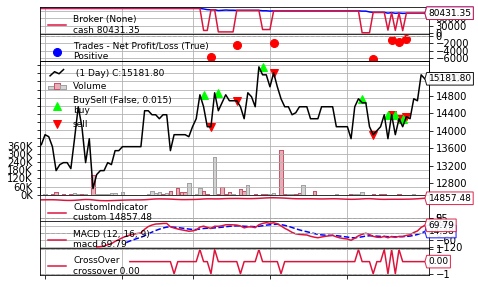

In [12]:
result, history = backtest(MAMAStrategy,df, verbose=False, return_history=True)
result

In [13]:
history['orders']

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
0,0,,2019-03-06,buy,14818.200195,6,88909.201172,666.819009,0.000000
1,0,,2019-03-08,sell,14090.900391,-6,88909.201172,634.090518,-4363.798828
2,0,,2019-03-12,buy,14863.599609,6,89181.597656,668.861982,0.000000
3,0,,2019-03-19,sell,14681.799805,-6,89181.597656,660.680991,-1090.798828
4,0,,2019-03-28,buy,15454.500000,5,77272.500000,579.543750,0.000000
5,0,,2019-04-02,sell,15318.200195,-5,77272.500000,574.432507,-681.499023
6,0,,2019-05-07,buy,14727.299805,6,88363.798828,662.728491,0.000000
7,0,,2019-05-10,sell,13909.099609,-6,88363.798828,625.909482,-4909.201172
8,0,,2019-05-16,buy,14363.599609,5,71817.998047,538.634985,0.000000
9,0,,2019-05-17,sell,14363.599609,-5,71817.998047,538.634985,0.000000
